<a href="https://colab.research.google.com/github/ontenkutsenko/NLP_Airbnb_Delisting_Prediction/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch langdetect deep_translator tqdm sentence-transformers xgboost google-cloud-translate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvid

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!python -m spacy download it_core_news_sm
!python -m spacy download pt_core_news_sm
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download ca_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 24.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 21.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
import spacy
import re
from deep_translator import GoogleTranslator
import time
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel, MarianMTModel, MarianTokenizer
from sentence_transformers import SentenceTransformer
import torch
from tqdm.notebook import tqdm
import pickle
from google.colab import files
from google.cloud import translate_v2 as translate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!gdown 1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8
!unzip '/content/Project Corpora.zip'
!rm '/content/Project Corpora.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8
From (redirected): https://drive.google.com/uc?id=1Y63uPJCSWvlefU-HYpuVumaiqgjHjpb8&confirm=t&uuid=7449f636-43b4-44bf-8a13-70f3087ce47c
To: /content/Project Corpora.zip
100% 55.4M/55.4M [00:02<00:00, 22.8MB/s]
Archive:  /content/Project Corpora.zip
  inflating: Project Corpora/test.xlsx  
  inflating: Project Corpora/test_reviews.xlsx  
  inflating: Project Corpora/train.xlsx  
  inflating: Project Corpora/train_reviews.xlsx  


In [5]:
df_train = pd.read_excel('/content/Project Corpora/train.xlsx')
df_train_reviews = pd.read_excel('/content/Project Corpora/train_reviews.xlsx')
df_test = pd.read_excel('/content/Project Corpora/test.xlsx')
df_test_reviews = pd.read_excel('/content/Project Corpora/test_reviews.xlsx')

In [ ]:
df_train.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [ ]:
df_train.shape

(6248, 4)

In [ ]:
df_train_reviews.head(5)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [ ]:
df_train_reviews_10 = df_train_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True) # limit to 10 reviews per property

In [ ]:
grouped_reviews = df_train_reviews_10.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()
grouped_reviews

,index,comments
0,1,"Very Nice. top Un lugar muy acogedor, buen lug..."
1,5,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...
2,8,Perfect location. Though it’s on a busy stree...
3,9,Lugar maravilhoso. Anfitriões muito atenciosos...
4,10,"Responsável, muito simpática sempre a escuta d..."
...,...,...
4240,6244,"Studio superbe, très propre et super bien équi..."
4241,6245,This a spacious apartment in the heart of Barr...
4242,6246,"Location, location, location!! If beach vibes,..."
4243,6247,No pudimos disfrutar de la estancia por un pro...


In [ ]:
# let's concatenate reviews to df_train
df_train = pd.merge(df_train, grouped_reviews, on='index', how='left')

In [ ]:
df_train['comments'] = df_train['comments'].fillna('')

In [ ]:
# same for test data
df_test_reviews = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
df_test = df_test.merge(df_test_reviews, on='index', how='left')
df_test['comments'] = df_test['comments'].fillna('')

# **Part 1: Multilingual**

# **Exploration**

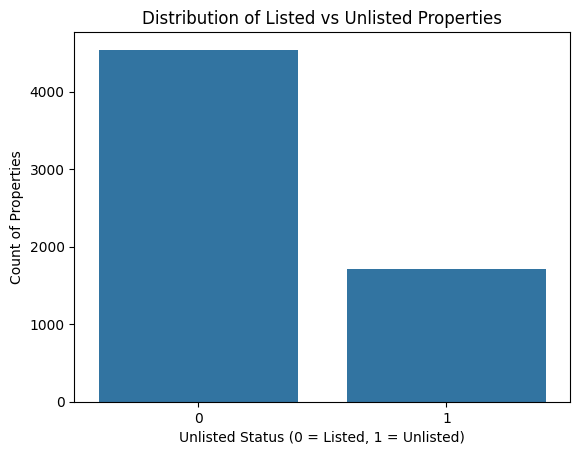

In [ ]:
# distribution of classes

sns.countplot(x='unlisted', data=df_train)
plt.title('Distribution of Listed vs Unlisted Properties')
plt.xlabel('Unlisted Status (0 = Listed, 1 = Unlisted)')
plt.ylabel('Count of Properties')
plt.show()

In [ ]:
# Let's create a wordcloud

def plot_word_cloud(text_series):
    text = ' '.join(text_series.dropna()).lower()
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Word Cloud for description


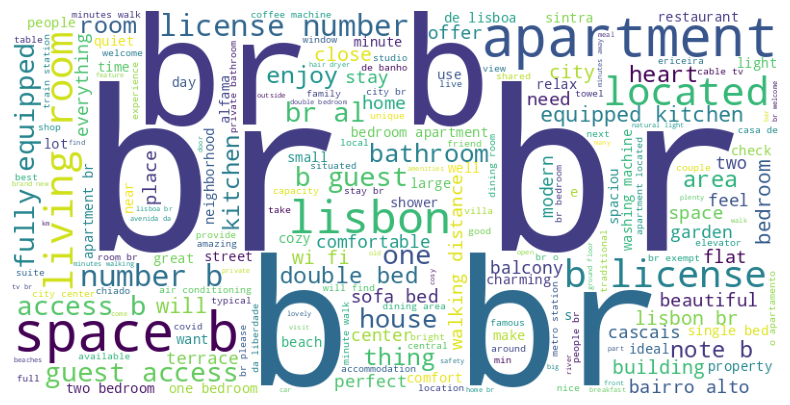

Word Cloud for host_about


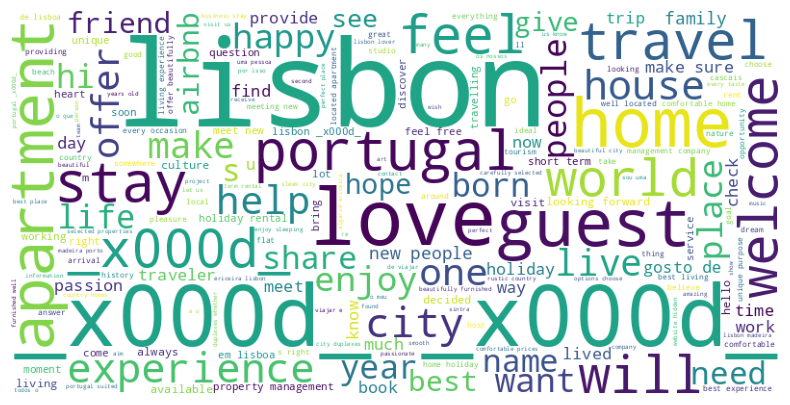

Word Cloud for comments


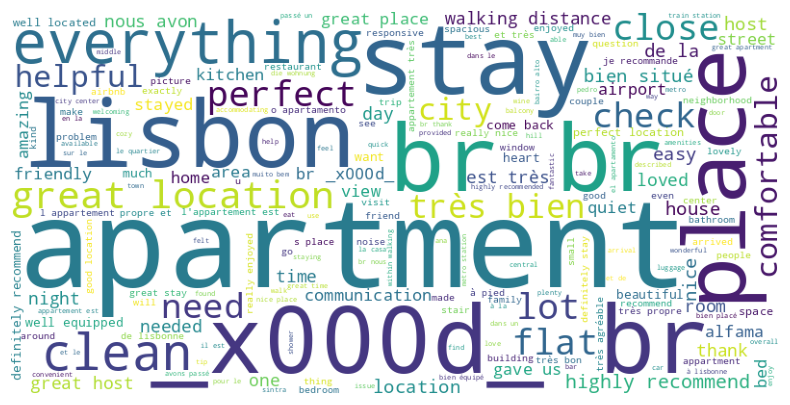

In [ ]:
# For df_train
for column in ['description', 'host_about']:
    print(f"Word Cloud for {column}")
    plot_word_cloud(df_train[column])

# For df_train_reviews
print("Word Cloud for comments")
plot_word_cloud(df_train_reviews['comments'])

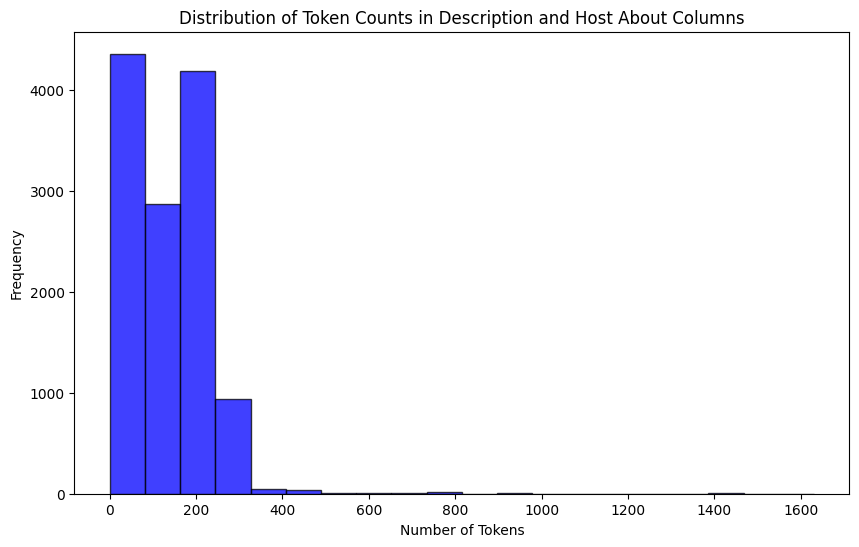

In [ ]:
def count_tokens(text):
    return len(word_tokenize(text))

# Get token counts for both columns
description_token_counts = df_train['description'].apply(count_tokens)
host_about_token_counts = df_train['host_about'].apply(count_tokens)

all_token_counts = list(description_token_counts) + list(host_about_token_counts)

# Create a histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(all_token_counts, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Token Counts in Description and Host About Columns')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Let's check examples where those unwanted words appear

def display_sentences_with_substring(df, column, substring, num_sentences=5):
    contains_substring = df[df[column].str.contains(substring, na=False, regex=False)]

    # Print examples
    print(f"Examples of sentences containing '{substring}' in {column}:")
    for example in contains_substring[column].head(num_sentences):
        print("-" * 80)
        print(example)
    print("-" * 80)

In [ ]:
# Display examples from 'description' containing "br"
display_sentences_with_substring(df_train, 'description', 'br')

# Display examples from 'comments' containing "_x000d"
display_sentences_with_substring(df_train_reviews, 'comments', 'x0')

Examples of sentences containing 'br' in description:
--------------------------------------------------------------------------------
This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and  There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!<br /><br /><b>Guest access</b><br />All rooms have key-card access.
--------------------------------------------------------------------------------
Trafaria’s House is a cozy and familiar villa where yo

# **Check for different languages**

In [8]:
# cleaning br and x000d
def clean_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special codes
        text = re.sub(r'_x000D_', '', text)
        # Strip any leading/trailing whitespace
        text = text.strip()
    return text

In [ ]:
df_train['description'] = df_train['description'].apply(clean_text)
df_train['host_about'] = df_train['host_about'].apply(clean_text)
df_train['comments'] = df_train['comments'].apply(clean_text)

In [9]:
# check for languages

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

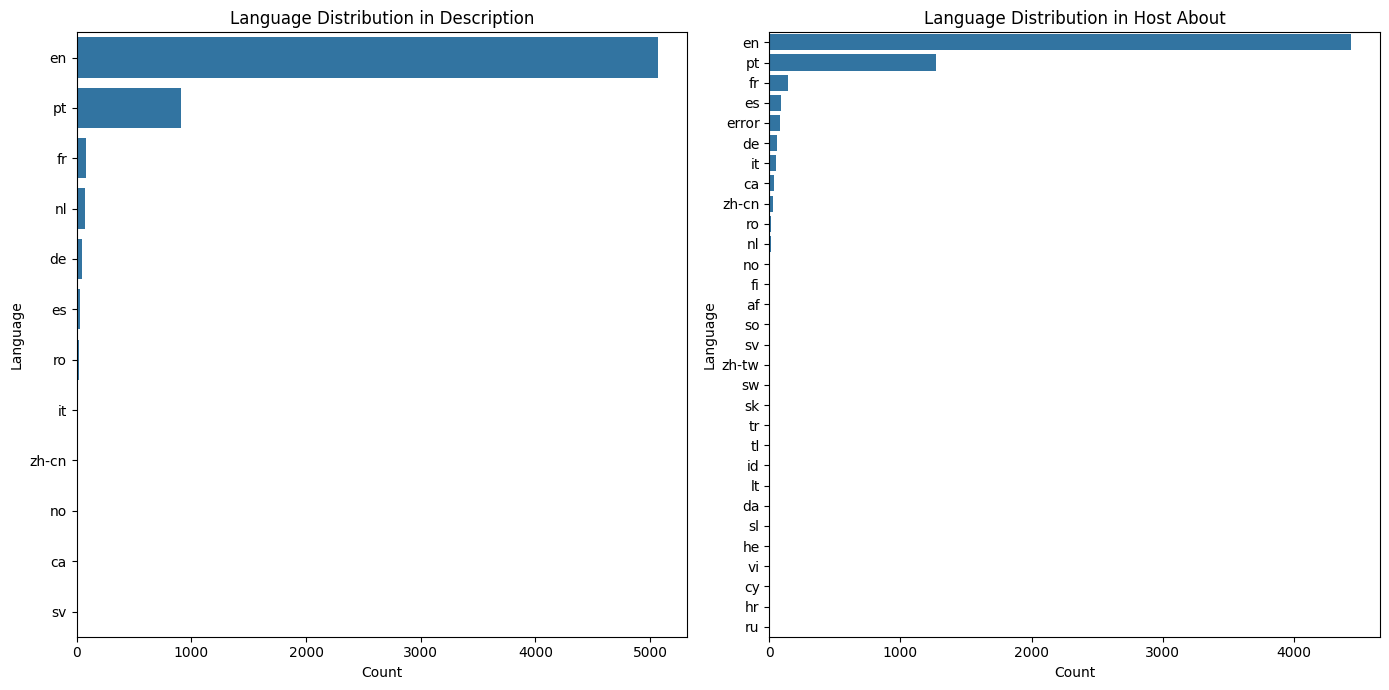

In [ ]:
# check language in the two columns of df_train
df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(y='lang_description', data=df_train, order = df_train['lang_description'].value_counts().index)
plt.title('Language Distribution in Description')
plt.xlabel('Count')
plt.ylabel('Language')

plt.subplot(1, 2, 2)
sns.countplot(y='lang_host_about', data=df_train, order = df_train['lang_host_about'].value_counts().index)
plt.title('Language Distribution in Host About')
plt.xlabel('Count')
plt.ylabel('Language')

plt.tight_layout()
plt.show()

In [ ]:
# checking for rows where language of description and host_about don't match
mismatch_mask = df_train['lang_description'] != df_train['lang_host_about']
percentage_mismatch = (mismatch_mask.sum() / len(df_train)) * 100
percentage_mismatch

23.367477592829704

# **SentenceEmbedding**

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
tqdm.pandas()

In [ ]:
def get_combined_embedding(text, model): # for cells with multiple sentences as reviews
    sentences = text.split('. ')
    sentence_embeddings = model.encode(sentences)
    return np.mean(sentence_embeddings, axis=0)

In [ ]:
df_train['description_embedding'] = df_train['description'].progress_apply(lambda x: get_combined_embedding(x, model))

  0%|          | 0/6248 [00:00<?, ?it/s]

In [ ]:
df_train['host_about_embedding'] = df_train['host_about'].progress_apply(lambda x: get_combined_embedding(x, model))

  0%|          | 0/6248 [00:00<?, ?it/s]

In [ ]:
df_train['comments_embedding'] = df_train['comments'].progress_apply(lambda x: get_combined_embedding(x, model))

  0%|          | 0/6248 [00:00<?, ?it/s]

#### SenEmb Classification Model

In [ ]:
df_train['description_embedding'] = df_train['description_embedding'].apply(lambda x: np.array(x))
df_train['host_about_embedding'] = df_train['host_about_embedding'].apply(lambda x: np.array(x))
df_train['comments_embedding'] = df_train['comments_embedding'].apply(lambda x: np.array(x))

In [ ]:
# with open('df_train.pkl', 'wb') as file:
#     pickle.dump(df_train, file)

# files.download('df_train.pkl')

In [ ]:
X = np.hstack((df_train['description_embedding'].values.tolist(), df_train['host_about_embedding'].values.tolist(), df_train['comments_embedding'].values.tolist()))
y = df_train['unlisted']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# standardize data
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),  # Increased dropout rate
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),  # Increased dropout rate
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='./logs')

In [ ]:
# Custom callback for plotting
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.plot()

    def plot(self):
        clear_output(wait=True)
        epochs = range(len(self.losses))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.acc, label='Training Accuracy')
        plt.plot(epochs, self.val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

plot_learning = PlotLearning()

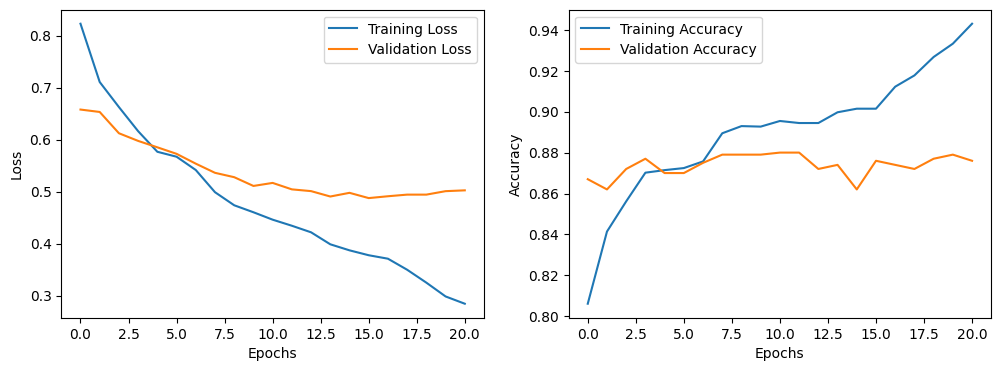

125/125 [==============================] - 1s 8ms/step - loss: 0.2844 - accuracy: 0.9430 - val_loss: 0.5025 - val_accuracy: 0.8760 - lr: 4.0000e-05


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint, tensorboard, plot_learning])

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

40/40 [==============================] - 0s 2ms/step
Accuracy: 0.8744
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       905
           1       0.76      0.79      0.78       345

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.84      1250
weighted avg       0.88      0.87      0.88      1250



In [ ]:
# random forest

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9749046623200885
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      7459
           1       0.98      0.71      0.82       670

    accuracy                           0.97      8129
   macro avg       0.98      0.86      0.91      8129
weighted avg       0.97      0.97      0.97      8129



# **TF-IDF**

In [ ]:
# lets reload the original dataframes for this part
df_train = pd.read_excel('/content/Project Corpora/train.xlsx')
df_train_reviews = pd.read_excel('/content/Project Corpora/train_reviews.xlsx')
df_test = pd.read_excel('/content/Project Corpora/test.xlsx')
df_test_reviews = pd.read_excel('/content/Project Corpora/test_reviews.xlsx')

In [ ]:
# clean the text from br and x000d
df_train['description'] = df_train['description'].apply(clean_text)
df_train['host_about'] = df_train['host_about'].apply(clean_text)
df_train_reviews['comments'] = df_train_reviews['comments'].apply(clean_text)

In [ ]:
df_train_reviews = df_train_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True) # limit again to 10 reviews per property

In [ ]:
# detect languages
df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)
df_train_reviews['lang_comments'] = df_train_reviews['comments'].apply(detect_language)

In [ ]:
# we will create now a new column in df_train for each comment and corresponding language
df_train_reviews['comment_number'] = df_train_reviews.groupby('index').cumcount() + 1
df_comments_pivot = df_train_reviews.pivot(index='index', columns='comment_number', values='comments').add_prefix('comment_')
df_languages_pivot = df_train_reviews.pivot(index='index', columns='comment_number', values='lang_comments').add_prefix('lang_comment_')

df_train = df_train.merge(df_comments_pivot, on='index', how='left').merge(df_languages_pivot, on='index', how='left')

In [ ]:
df_train = df_train.fillna('')

In [ ]:
df_train.head()

,index,description,host_about,unlisted,lang_description,lang_host_about,comment_1,comment_2,comment_3,comment_4,...,lang_comment_1,lang_comment_2,lang_comment_3,lang_comment_4,lang_comment_5,lang_comment_6,lang_comment_7,lang_comment_8,lang_comment_9,lang_comment_10
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,Very Nice.,top,"Un lugar muy acogedor, buen lugar donde hosped...",The property is absolutely clean and stylish. ...,...,en,en,es,en,en,fr,en,pt,en,en
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,,,,,...,,,,,,,,,,
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,,,,,...,,,,,,,,,,
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en,,,,,...,,,,,,,,,,
4,5,Joli appartement en bordure de mer. 2 min. a ...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,Vista fabulosa.Bom apartamento. Localização fa...,"Schöne Aussicht, sehr sauber, tolle Lage .",Lovely apartment with great views of the beach...,"Spectacular location, awsome place",...,pt,de,en,en,de,en,es,en,fr,en


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

# Load spacy models for different languages
spacy_models = {
    'en': spacy.load('en_core_web_sm'),
    'de': spacy.load('de_core_news_sm'),
    'it': spacy.load('it_core_news_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'es': spacy.load('es_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'ca': spacy.load('ca_core_news_sm')
}

# Define stop words for each language
stop_words_dict = {
    'en': stopwords.words('english'),
    'de': stopwords.words('german'),
    'it': stopwords.words('italian'),
    'pt': stopwords.words('portuguese'),
    'es': stopwords.words('spanish'),
    'fr': stopwords.words('french'),
    'ca': stopwords.words('catalan')
}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text, lang):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Removing stopwords
    if lang in stop_words_dict:
        stop_words = set(stop_words_dict[lang])
        words = [word for word in words if word not in stop_words]
    # Lemmatization using spacy
    if lang in spacy_models:
        nlp = spacy_models[lang]
        doc = nlp(' '.join(words))
        words = [token.lemma_ for token in doc]
    return ' '.join(words)

In [ ]:
df_train['clean_description'] = df_train.progress_apply(lambda row: preprocess_text(row['description'], row['lang_description']), axis=1)
df_train['clean_host_about'] = df_train.progress_apply(lambda row: preprocess_text(row['host_about'], row['lang_host_about']), axis=1)

df_train['clean_comment_1'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_1'], row['lang_comment_1']), axis=1)
df_train['clean_comment_2'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_2'], row['lang_comment_2']), axis=1)
df_train['clean_comment_3'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_3'], row['lang_comment_3']), axis=1)
df_train['clean_comment_4'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_4'], row['lang_comment_4']), axis=1)
df_train['clean_comment_5'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_5'], row['lang_comment_5']), axis=1)
df_train['clean_comment_6'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_6'], row['lang_comment_6']), axis=1)
df_train['clean_comment_7'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_7'], row['lang_comment_7']), axis=1)
df_train['clean_comment_8'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_8'], row['lang_comment_8']), axis=1)
df_train['clean_comment_9'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_9'], row['lang_comment_9']), axis=1)
df_train['clean_comment_10'] = df_train.progress_apply(lambda row: preprocess_text(row['comment_10'], row['lang_comment_10']), axis=1)

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

#### TF-IDF Classification Model

In [ ]:
df_train['combined_text_clean'] = (
    df_train['clean_description'] + " " +
    df_train['clean_host_about'] + " " +
    df_train['clean_comment_1'] + " " +
    df_train['clean_comment_2'] + " " +
    df_train['clean_comment_3'] + " " +
    df_train['clean_comment_4'] + " " +
    df_train['clean_comment_5'] + " " +
    df_train['clean_comment_6'] + " " +
    df_train['clean_comment_7'] + " " +
    df_train['clean_comment_8'] + " " +
    df_train['clean_comment_9'] + " " +
    df_train['clean_comment_10']
).str.strip()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['combined_text_clean'], df_train['unlisted'], test_size=0.2, random_state=42, stratify=df_train['unlisted'])

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

In [ ]:
X_train_tfidf = tfidf.fit_transform(tqdm(X_train, desc="TF-IDF fitting"))
X_test_tfidf = tfidf.transform(X_test)

TF-IDF fitting:   0%|          | 0/4998 [00:00<?, ?it/s]

In [ ]:
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8728
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       908
           1       0.75      0.81      0.78       342

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.84      1250
weighted avg       0.88      0.87      0.87      1250



# **Test Data**

In [ ]:
df_test['description_embedding'] = df_test['description'].progress_apply(lambda x: get_combined_embedding(x, model))
df_test['host_about_embedding'] = df_test['host_about'].progress_apply(lambda x: get_combined_embedding(x, model))
df_test['comments_embedding'] = df_test['comments'].progress_apply(lambda x: get_combined_embedding(x, model))

  0%|          | 0/4564 [00:00<?, ?it/s]

  0%|          | 0/4564 [00:00<?, ?it/s]

  0%|          | 0/4564 [00:00<?, ?it/s]

In [ ]:
X_test = np.hstack((df_test['description_embedding'].values.tolist(), df_test['host_about_embedding'].values.tolist(), df_test['comments_embedding'].values.tolist()))
y_pred = rf_classifier.predict(X_test) # predictions for test

NameError: name 'np' is not defined

# **Part 2: With Translation**

In [6]:
df_train_translation = pd.read_excel('/content/Project Corpora/train.xlsx')
df_train_reviews_translation = pd.read_excel('/content/Project Corpora/train_reviews.xlsx')
df_test_translation = pd.read_excel('/content/Project Corpora/test.xlsx')
df_test_reviews_translation = pd.read_excel('/content/Project Corpora/test_reviews.xlsx')

In [10]:
# before we translate we make a first cleaning
df_train_translation['description'] = df_train_translation['description'].apply(clean_text)
df_train_translation['host_about'] = df_train_translation['host_about'].apply(clean_text)
df_train_reviews_translation['comments'] = df_train_reviews_translation['comments'].apply(clean_text)

df_test_translation['description'] = df_test_translation['description'].apply(clean_text)
df_test_translation['host_about'] = df_test_translation['host_about'].apply(clean_text)
df_test_reviews_translation['comments'] = df_test_reviews_translation['comments'].apply(clean_text)

In [11]:
df_train_reviews_translation_10 = df_train_reviews_translation.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True) # limit to 10 reviews per property
df_test_reviews_translation_10 = df_test_reviews_translation.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True) # limit to 10 reviews per property

In [12]:
df_train_translation['lang_description'] = df_train_translation['description'].apply(detect_language)
df_train_translation['lang_host_about'] = df_train_translation['host_about'].apply(detect_language)
df_train_reviews_translation_10['lang_comments'] = df_train_reviews_translation_10['comments'].apply(detect_language)

df_test_translation['lang_description'] = df_test_translation['description'].apply(detect_language)
df_test_translation['lang_host_about'] = df_test_translation['host_about'].apply(detect_language)
df_test_reviews_translation_10['lang_comments'] = df_test_reviews_translation_10['comments'].apply(detect_language)

ValueError: Could not interpret value `lang_description` for `y`. An entry with this name does not appear in `data`.

<Figure size 1400x700 with 0 Axes>

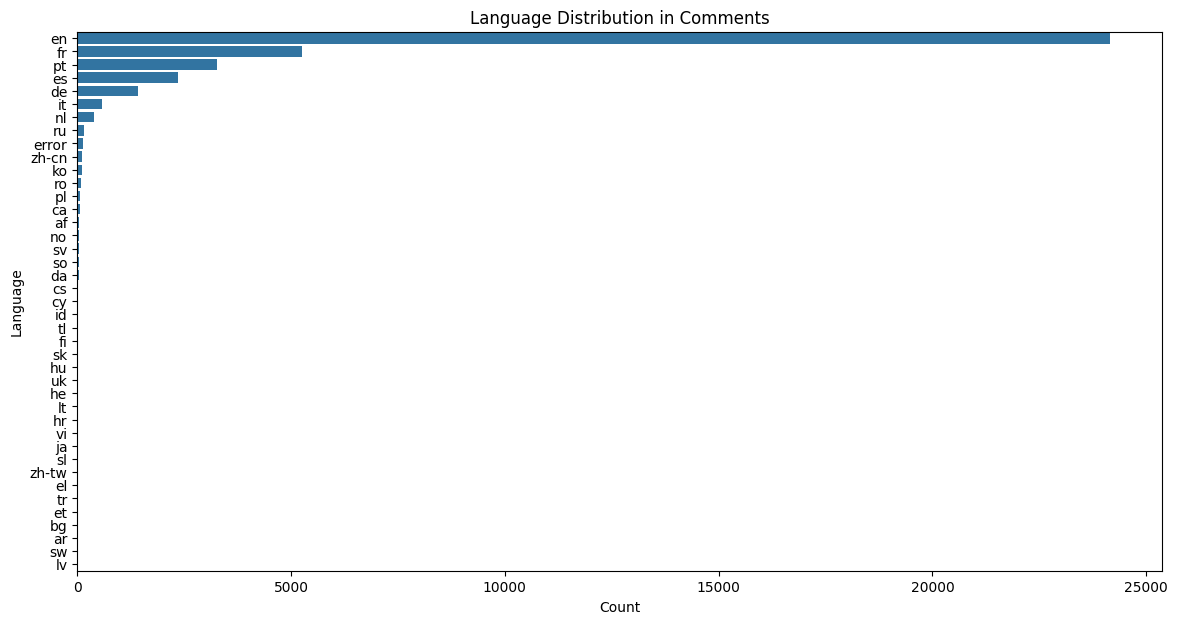

In [13]:
plt.figure(figsize=(14, 7))
sns.countplot(y='lang_comments', data=df_train_reviews_translation_10, order = df_train_reviews_translation_10['lang_comments'].value_counts().index)
plt.title('Language Distribution in Comments')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()

In [18]:
# let's translate with google cloud translate all non english comments, description and host_about to english
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ="/content/cloud_credentials.json"
translate_client = translate.Client()

def translate_text(text, target_language='en'):
    if text:
        result = translate_client.translate(text, target_language=target_language)
        return result['translatedText']
    return text

In [19]:
translated_comments = []
for _, row in tqdm(df_train_reviews_translation_10.iterrows(), total=df_train_reviews_translation_10.shape[0], desc="Translating comments"):
    if row['lang_comments'] != 'en':
        translated_comments.append(translate_text(row['comments']))
    else:
        translated_comments.append(row['comments'])
df_train_reviews_translation_10['translated_comments'] = translated_comments

translated_description = []
for _, row in tqdm(df_train_translation.iterrows(), total=df_train_translation.shape[0], desc="Translating descriptions"):
    if row['lang_description'] != 'en':
        translated_description.append(translate_text(row['description']))
    else:
        translated_description.append(row['description'])
df_train_translation['translated_description'] = translated_description

translated_host_about = []
for _, row in tqdm(df_train_translation.iterrows(), total=df_train_translation.shape[0], desc="Translating host about"):
    if row['lang_host_about'] != 'en':
        translated_host_about.append(translate_text(row['host_about']))
    else:
        translated_host_about.append(row['host_about'])
df_train_translation['translated_host_about'] = translated_host_about

Translating comments:   0%|          | 0/38641 [00:00<?, ?it/s]

Translating descriptions:   0%|          | 0/6248 [00:00<?, ?it/s]

Translating host about:   0%|          | 0/6248 [00:00<?, ?it/s]

In [20]:
df_train_reviews_translation_10.to_csv('/content/translated_reviews.csv', index=False)
df_train_translation.to_csv('/content/translated_train_translation.csv', index=False)

In [21]:
# same for test
translated_comments_test = []
for _, row in tqdm(df_test_reviews_translation_10.iterrows(), total=df_test_reviews_translation_10.shape[0], desc="Translating test comments"):
    if row['lang_comments'] != 'en':
        translated_comments_test.append(translate_text(row['comments']))
    else:
        translated_comments_test.append(row['comments'])
df_test_reviews_translation_10['translated_comments'] = translated_comments_test

# Translate non-English descriptions and host_about in df_test_translation
translated_description_test = []
for _, row in tqdm(df_test_translation.iterrows(), total=df_test_translation.shape[0], desc="Translating test descriptions"):
    if row['lang_description'] != 'en':
        translated_description_test.append(translate_text(row['description']))
    else:
        translated_description_test.append(row['description'])
df_test_translation['translated_description'] = translated_description_test

translated_host_about_test = []
for _, row in tqdm(df_test_translation.iterrows(), total=df_test_translation.shape[0], desc="Translating test host about"):
    if row['lang_host_about'] != 'en':
        translated_host_about_test.append(translate_text(row['host_about']))
    else:
        translated_host_about_test.append(row['host_about'])
df_test_translation['translated_host_about'] = translated_host_about_test

Translating test comments:   0%|          | 0/4344 [00:00<?, ?it/s]

Translating test descriptions:   0%|          | 0/695 [00:00<?, ?it/s]

Translating test host about:   0%|          | 0/695 [00:00<?, ?it/s]

In [22]:
df_test_reviews_translation_10.to_csv('/content/translated_test_reviews.csv', index=False)
df_test_translation.to_csv('/content/translated_test_translation.csv', index=False)

## Let's reload the translated data again

In [25]:
df_train_translated = pd.read_csv('/content/translated_train_translation.csv')
df_train_reviews_translated = pd.read_csv('/content/translated_reviews.csv')
df_test_translated = pd.read_csv('/content/translated_test_translation.csv')
df_test_reviews_translated = pd.read_csv('/content/translated_test_reviews.csv')

In [26]:
df_train_reviews_translated.head(30)

,index,comments,lang_comments,translated_comments
0,1,Very Nice.,en,Very Nice.
1,1,top,en,top
2,1,"Un lugar muy acogedor, buen lugar donde hosped...",es,"A very cozy place, a good place to stay, very ..."
3,1,The property is absolutely clean and stylish. ...,en,The property is absolutely clean and stylish. ...
4,1,"Everything is correct, like the photos said. B...",en,"Everything is correct, like the photos said. B..."
5,1,Personnes très agréable et très attentionné po...,fr,Very pleasant people and very attentive to our...
6,1,You have to be there,en,You have to be there
7,1,Minha estadia foi quando estava comecando o su...,pt,My stay was when the Corona outbreak was start...
8,1,Great location and very good communication,en,Great location and very good communication
9,1,Beside to big street and park.You can find the...,en,Beside to big street and park.You can find the...
